In [2]:
import numpy as np
import sys
import os
import importlib
sys.path.append(os.path.abspath('../'))

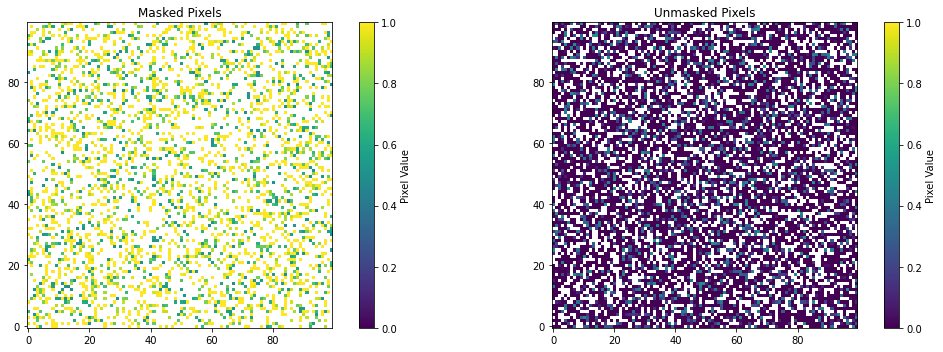

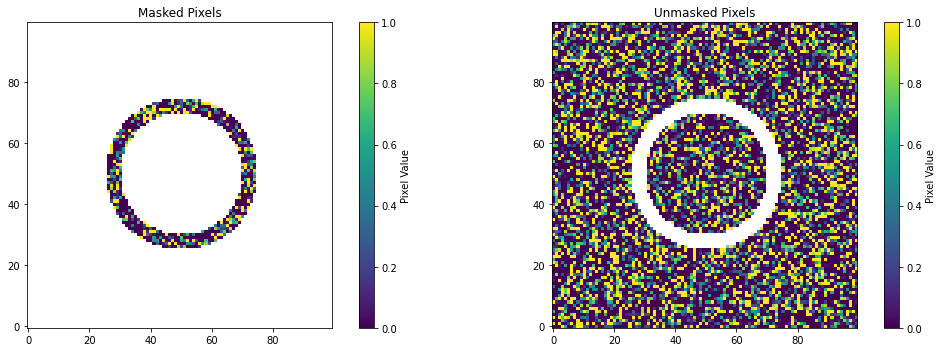

In [2]:
# importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.base.visualizer import MaskInspector
from uvotimgpy.utils.image_operation import UnifiedMask
from photutils.aperture import CircularAnnulus

# 使用示例
# 创建测试图像
image = np.random.normal(0, 1, (100, 100))

# 1. 从布尔数组创建并转换为ApertureMask
bool_mask = image > 0.5
unified_mask1 = UnifiedMask(bool_mask)
aperture_mask1 = unified_mask1.to_aperture_mask()

# 2. 从ApertureMask创建并转换为布尔数组
annulus = CircularAnnulus((50, 50), r_in=20, r_out=25)
aperture_mask2 = annulus.to_mask(method='center')
unified_mask2 = UnifiedMask(aperture_mask2, image_shape=image.shape)
bool_array2 = unified_mask2.to_bool_array()

# 3. 在MaskInspector中使用
inspector1 = MaskInspector(image, bool_mask)
inspector1.show_comparison(vmin=0,vmax=1)
inspector2 = MaskInspector(image, bool_array2)
inspector2.show_comparison(vmin=0,vmax=1)

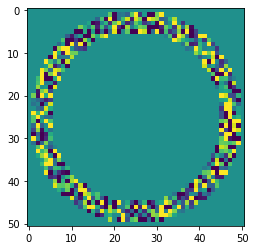

In [19]:
import matplotlib.pyplot as plt

image = np.random.normal(0, 1, (100, 100))
mask = image > 0.5
annulus = CircularAnnulus((50, 50), r_in=20, r_out=25)
annulus_mask = annulus.to_mask(method='center')
annulus_data = annulus_mask.multiply(image) # annulus_data与annulus_mask同样大小，都被裁减过
ring_mask = annulus_mask.data > 0 # ring_mask 是个被裁减过的bool array
#valid_data = annulus_data[ring_mask & ~mask[ring_mask]]
valid_data = annulus_data[ring_mask]
plt.imshow(annulus_data, vmin=-1,vmax=1)
plt.show()


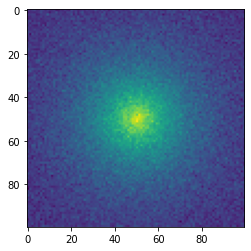

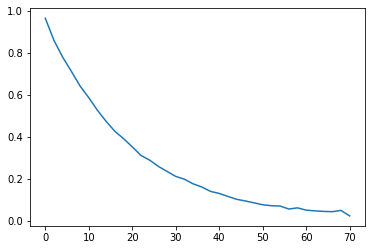

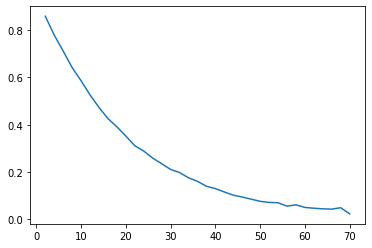

In [28]:
import astropy.units as u
import uvotimgpy.base.unit_conversion
importlib.reload(uvotimgpy.base.unit_conversion)
import uvotimgpy.utils.image_operation
importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.utils.image_operation import RadialProfile
import matplotlib.pyplot as plt

# 创建一个测试图像：中心亮度高，向外衰减
size = 100
center = (size//2, size//2)
y, x = np.ogrid[-size//2:size//2, -size//2:size//2]
r = np.sqrt(x*x + y*y)
image = np.exp(-r/20)  # 指数衰减

# 添加一些随机噪声
np.random.seed(42)
image += np.random.normal(0, 0.05, image.shape)

plt.imshow(image)
plt.show()

# 1. 使用普通数组
profile = RadialProfile(image, center=center, step=2, start=0, end=80)
radii, values = profile.get_radial_profile()
plt.plot(radii, values)
plt.show()
#profile.plot()

# 2. 使用带单位的数组
image_with_unit = image * u.adu

profile_with_unit = RadialProfile(image_with_unit, center=center, step=2, start=2, end=80)
#profile_with_unit.plot()
radii, values = profile_with_unit.get_radial_profile()
plt.plot(radii, values)
plt.show()

In [6]:
import uvotimgpy.utils.image_operation
importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.utils.image_operation import ImageDistanceCalculator
import astropy.units as u

from astropy.io import fits
from astropy.wcs import WCS
hdul = fits.open('/Users/zexixing/Research/29P/data/29p_raw_oct/05000049002/uvot/image/sw05000049002uw1_sk.img.gz')
image = hdul[1].data
wcs = WCS(hdul[1].header)
hdul.close()

#image = np.zeros((10, 12))
#coords = (3*u.pixel, 12*u.pixel)
coords = (1000*u.pixel, 1000*u.pixel)

max_dist = ImageDistanceCalculator.from_corners(image, coords, return_coords=False, distance_method='min', wcs=wcs, scale = 0.5*u.arcsec/u.pixel)
print(max_dist)

0d05m54.31138636s
